In [8]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as k
import numpy as np
from models import dataset_ops
from models import vectorization_ops
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, accuracy_score
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)  # show all columns
GPUs = tf.config.list_physical_devices('GPU')
if GPUs is None or len(GPUs) == 0:
    print("WARNING: No GPU, all there is is:")
    for device in tf.config.list_physical_devices():
        print(f'- {device}')
else:
    for gpu in GPUs:
        tf.config.experimental.set_memory_growth(gpu, True)
        print("Initialized", gpu)

Initialized PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
data_train, data_validation, data = dataset_ops.load_data(split_ratio=0.3, random_state=42)
data.groupby('type').aggregate('count'), data_train.groupby('type').aggregate('count'), data_validation.groupby('type').aggregate('count'),

(         url
 type        
 0     380128
 1     133956,
          url
 type        
 0     266089
 1      93769,
          url
 type        
 0     114039
 1      40187)

In [3]:
word_vectorizer = vectorization_ops.create_word_vectorizer(data_train['url'])
char_vectorizer = vectorization_ops.create_char_vectorizer(data_train['url'])
LC = len(char_vectorizer.word_counts)
LW = len(word_vectorizer.vocabulary_)

print('Char vocab size:', LC)
print('Word vocab size:', LW)

Char vocab size: 157
Word vocab size: 500


In [4]:
dataset_train = dataset_ops.create_dataset_generator(word_vectorizer, char_vectorizer, data_train)\
    .shuffle(10000)\
    .prefetch(10000) #.batch(15*1024)
dataset_validation = dataset_ops.create_dataset_generator(word_vectorizer, char_vectorizer, data_validation)\
    .shuffle(10000)\
    .prefetch(10000) #.batch(15*1024)

print('Train:', dataset_train.element_spec, '\nValid:', dataset_validation.element_spec)

Train: ({'word': TensorSpec(shape=(200,), dtype=tf.float64, name=None), 'char': TensorSpec(shape=(200,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None)) 
Valid: ({'word': TensorSpec(shape=(200,), dtype=tf.float64, name=None), 'char': TensorSpec(shape=(200,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word (InputLayer)               [(None, 200)]        0                                            
__________________________________________________________________________________________________
char (InputLayer)               [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 200, 16)      8032        word[0][0]                       
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 200, 16)      2544        char[0][0]                       
____________________________________________________________________________________________

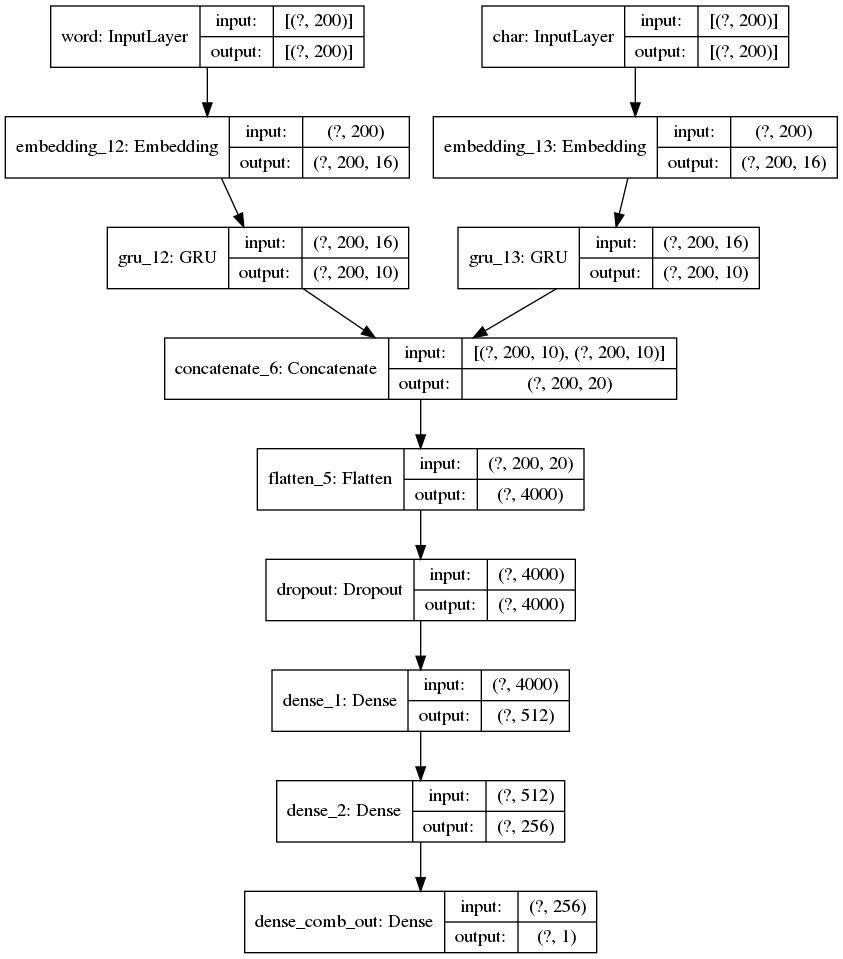

In [12]:
def create_url_net(input_length, emb_dim, gru_cells):
    word_input = k.layers.Input(shape=[input_length], name='word')
    char_input = k.layers.Input(shape=[input_length], name='char')

    x = k.layers.concatenate([
        k.layers.GRU(gru_cells, return_sequences=True)(k.layers.Embedding(2+LW, emb_dim, mask_zero=True)(word_input)),
        k.layers.GRU(gru_cells, return_sequences=True)(k.layers.Embedding(2+LC, emb_dim, mask_zero=True)(char_input)),
    ])
    x = k.layers.Flatten()(x)
    x = k.layers.Dropout(0.5, name=f'dropout')(x)
    x = k.layers.Dense(512, name=f'dense_1', activation='relu')(x)
    x = k.layers.Dense(256, name=f'dense_2', activation='relu')(x)
    x = k.layers.Dense(1, activation='sigmoid', name='dense_comb_out')(x)

    model = k.models.Model(inputs=[word_input, char_input], outputs=[x])
    return model

model = create_url_net(
    input_length=200,
    emb_dim=16,
    gru_cells=10,
)
model.compile(
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']#, k.metrics.Precision(), k.metrics.Recall()]
)
#     loss='binary_crossentropy',
model.summary()
k.utils.plot_model(model, show_shapes=True)

In [14]:
bs=256*16

model.fit(
    dataset_train.batch(bs),
    epochs=100,
    validation_data=dataset_validation.batch(bs),
    callbacks=[
        k.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        k.callbacks.ModelCheckpoint('./checkpoints', verbose=0)
    ],
)

Epoch 1/100
     88/Unknown - 194s 2s/step - loss: 0.2554 - binary_accuracy: 0.8931

In [24]:
model.save('recurrent')

INFO:tensorflow:Assets written to: recurrent/assets


In [5]:
bs=256*16
model = k.models.load_model('recurrent')

In [25]:
X_validation, y_validation = np.array([*dataset_validation.as_numpy_iterator()]).T
# X_validation = np.array([item['word'] for item in X_validation])
# X_validation = np.array([item['char'] for item in X_validation])
X_validation = np.array([(item['word'],item['char']) for item in X_validation])
X_validation = tf.data.Dataset.from_tensor_slices(((X_validation[:,0,:], X_validation[:,1,:]), )).batch(bs)
y_validation = y_validation.astype('int32')

y_hat = model.predict(X_validation).ravel()

In [26]:
fpr, tpr, thresholds = roc_curve(y_validation, y_hat)
auc_ = auc(fpr, tpr)
best_threshold = thresholds[np.argmax(-fpr + tpr)]

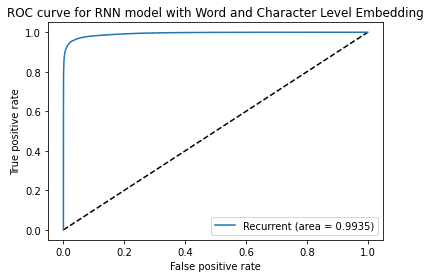

In [32]:
model_name = "Recurrent"
model_full_name = "RNN model with Word and Character Level Embedding"

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'{model_name} (area = {auc_:.4f})')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve for {model_full_name}')
plt.legend(loc='best')
plt.savefig(f'../plots/{model_name.replace(" ", "_").lower()}_roc.pdf')
plt.show()

In [28]:
y_hat_01 = np.zeros_like(y_hat)
y_hat_01[y_hat >= best_threshold] = 1

np.unique(y_hat_01)

array([0., 1.], dtype=float32)

In [29]:
precision_recall_fscore_support(y_validation, y_hat_01, beta=1, average='binary'), \
    tpr[np.argmax(-fpr + tpr)], fpr[np.argmax(-fpr + tpr)], \
    accuracy_score(y_validation, y_hat_01)

((0.927536231884058, 0.9539403289621021, 0.9405530066979071, None),
 0.9539403289621021,
 0.026262945132805443,
 0.968578579487246)

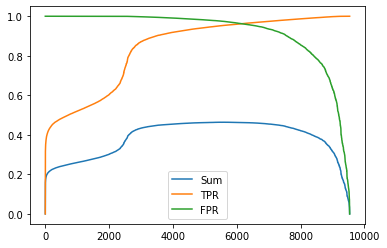

In [30]:
plt.plot((-fpr + tpr) / 2, label='Sum')
plt.plot(tpr, label='TPR')
plt.plot(1-fpr, label='FPR')
plt.legend()

In [31]:
np.save("fpr_tpr/rnn-fpr", fpr)
np.save("fpr_tpr/rnn-tpr", tpr)